# Determine whether within-host variants detected in Wisconsin transmission pairs are present on the SARS-CoV2 phylogeny

May 8, 2020

Kat and Gage have sequenced SARS-CoV2 from putative transmission pairs in Wisconsin. In this data, they see that there is a lot of shared within-host diversity between pairs, but that a lot of this diversity is also shared among non-transmission pairs of samples. This is concerning and a little weird. This was also observed in [this paper](https://www.medrxiv.org/content/10.1101/2020.04.24.20078691v1) that Gage found, although I have not read it closely. 

There are a few questions that I think would be nice to try to address by looking at the phylogeny: 

1. Are any of these recurrent within-host mutations also ones identified as problematic/likely errors by people looking at consensus data? If so, these should probably be excluded. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)

2. How frequently do within-host variants appear in consensus sequences? I would hypothesize that the vast majority of within-host variation being generated is not particularly advantageous. In this scenario, we would expect to observe only a small fraction of these within-host variants on the phylogeny, and when we do, we expect them to be primarily observed at terminal nodes rather than on internal branches.

3. Do any of these within-host variants appear downstream at the consensus level from the host they were sampled in? By this I mean, if we observe a within-host variant in a particular person, is that infection upstream of later sampled cases? If so, is that variant detected at consensus level in any of those offspring infections? We will see. 


I think that for this analysis, it may be worthwhile to try to help them set up a Wisconsin-focused community build. This could use the new snakemake rules to generate a community build that focuses on Wisconsin but also pulls in sequences from elsewhere. This might be a nice thing to help facilitate and it would absolutely provide them with a better tree for inference than their current Wisconsin-only build. 

Kat mapped the genomes to this reference: MN908947.3.

This is a link to their local nextstrain build http://35.226.31.45/Wisconsin?branchLabel=aa&c=clade_membership&r=location

One note here is that indels are labelled differently in Kat's output files than in the nextstrain tree. In the nextstrain tree, `-505A` means that there was an A insertion at 505. `A505-` means that there was a deletion at 505. 

### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

import copy
from scipy.special import binom
import datetime as dt

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from IPython.display import HTML


try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
    
import rpy2
%load_ext rpy2.ipython

## Read in VCF data and output SNVs to query into a dataframe

In [2]:
def return_list_of_vcfs(vcf_directory):
    vcf_list = []
    for f in glob.glob(vcf_directory + "*intersection.csv"):
        vcf_list.append(f)
    return(vcf_list)

In [3]:
def read_in_intersection_snvs(vcf_list, vcf_directory):
    within_host_df = pd.DataFrame()
    
    for v in vcf_list:
        # pull out sampleid
        sampleid = v.replace(vcf_directory,"").replace("intersection.csv","")
        
        d = pd.read_csv(v, sep="\t")
        d['sampleid'] = sampleid
        within_host_df = within_host_df.append(d)
        
    return(within_host_df)

In [4]:
def separate_snvs_from_frameshift(within_host_df):
    # first, separate out and format snvs_df
    snvs_df = within_host_df[(within_host_df['annotation'] == "missense") | (within_host_df['annotation'] == "synonymous") | (within_host_df['annotation'] == "stop")]
    snvs_df['aa_site'] = snvs_df['aa_chage'].str[3:-3]
    snvs_df['wt_aa'] = snvs_df['aa_chage'].str[0:3]
    snvs_df['mut_aa'] = snvs_df['aa_chage'].str[-3:]
    
    # add in columns for nucleotide changes 
    snvs_df['nt_ref'] = snvs_df['nt_change'].str.split(">",expand=True)[0].str[-1:]
    snvs_df['nt_mut'] = snvs_df['nt_change'].str.split(">",expand=True)[1]
    
    # now, separate out and format indels dataframe
    indels_df = within_host_df[(within_host_df['annotation'] == "frameshift") | (within_host_df['annotation'] == "frameshift&stop")]
    indels_df['nt_ref'] = indels_df['nt_change'].str.split("dup",expand=True)[0].str[-1:]
    
    
    return(snvs_df, indels_df)

In [5]:
def read_strain_names_from_csv(strain_names_file):
    strain_names_dict = {}
    
    with open(strain_names_file, "r") as infile: 
        for line in infile:
            if "Sample identifier" not in line:
                tube_number = line.split("\t")[1]
                strain_name = line.split("\t")[0].replace("hCoV-19/","")
                
                # there are 2 sets of tube numbers, some with leading 0s and others without. I am pretty sure we
                # want the ones with leading 0s; there are also some we don't want that have non-numeric tube #s
                if tube_number.isdigit() and tube_number.startswith("0"):
                    strain_names_dict[str(int(tube_number))] = strain_name
                    
    return(strain_names_dict)

In [6]:
def convert_number_to_strain(sampleid, strain_names_dict):
    if sampleid in strain_names_dict:
        strain_name = strain_names_dict[sampleid]
    else:
        strain_name = "unknown"
        print(sampleid)
    return(strain_name)

In [7]:
def add_in_strain_column(df, strain_names_dict):
    temp_df = pd.DataFrame(df)
    strain_name = temp_df['sampleid'].apply(convert_number_to_strain, args=[strain_names_dict])
    #strain_name = temp_df['sampleid'].apply(lambda x: "USA/" + tube_number_conversion[x] + "/2020")
    temp_df["strain_name"] = strain_name
    return(temp_df)

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled).

In [8]:
strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/spreadsheet-with-strain-names.tsv"
strain_names_dict = read_strain_names_from_csv(strain_names_file)

In [9]:
vcf_directory = "/Users/lmoncla/src/ncov-WI-within-host/data/VCFs/"
vcfs = return_list_of_vcfs(vcf_directory)
all_intersection_variants = read_in_intersection_snvs(vcfs, vcf_directory)
all_intersection_variants = add_in_strain_column(all_intersection_variants, strain_names_dict)
snvs_only, indels_only = separate_snvs_from_frameshift(all_intersection_variants)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [10]:
# add in a column for the nucleotide mutation so that it is in the same format as the annotation on nextstrain
snvs_only['nuc_muts'] = snvs_only['nt_ref'] + snvs_only["POS"].astype(int).astype(str) + snvs_only['nt_mut']

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
def format_indels(row):
    
    if "dup" in row['nt_change']:
        split_char = "dup"
        variant = row['nt_change'].split(split_char)[1]
        new_value = "-" + str(int(row["POS"])) + variant
    
    elif "del" in row['nt_change']:
        split_char = "del"
        variant = row['nt_change'].split(split_char)[1]
        new_value = str(int(row['POS'])) +  variant + "-"
    
    return(new_value)

In [12]:
def return_indel_type(row):
    
    if "dup" in row['nt_change']:
        type_change = "insertion"
     
    elif "del" in row['nt_change']:
        type_change = "deletion"
    
    return(type_change)

In [13]:
# add a column with formatted indel that matches nextstrain
indels_only['nuc_muts'] = indels_only.apply(format_indels, axis=1)
indels_only['type_mut'] = indels_only.apply(return_indel_type, axis=1)
indels_only.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,SNP,POS,REF,annotation,gene_x,nt_change,aa_chage,rep1_percent,rep2_percent,%,sampleid,strain_name,nt_ref,nuc_muts,type_mut
0,1,ORF1ab_875dupA_Leu293fs_frameshift,1135.0,G,frameshift,ORF1ab,875dupA,Leu293fs,2.23,1.96,2.095,117,USA/WI-UW-110/2020,5,-1135A,insertion
3,4,ORF1ab_6435dupT_Leu2146fs_frameshift,6696.0,C,frameshift,ORF1ab,6435dupT,Leu2146fs,6.63,7.57,7.100,117,USA/WI-UW-110/2020,5,-6696T,insertion
5,8,ORF1ab_10817dupT_Leu3606fs_frameshift,11074.0,C,frameshift,ORF1ab,10817dupT,Leu3606fs,2.67,3.02,2.845,117,USA/WI-UW-110/2020,7,-11074T,insertion
12,17,ORF1ab_15705dupT_Val5236fs_frameshift,15965.0,G,frameshift,ORF1ab,15705dupT,Val5236fs,6.31,5.98,6.145,117,USA/WI-UW-110/2020,5,-15965T,insertion
13,18,ORF1ab_18109dupT_Ser6037fs_frameshift,18368.0,G,frameshift,ORF1ab,18109dupT,Ser6037fs,5.92,4.22,5.070,117,USA/WI-UW-110/2020,9,-18368T,insertion


In [14]:
# Split into only low frequency, here defined as <50%; I don't really want to query the fixed variants here 
low_freq_snvs_only = snvs_only[snvs_only["%"] < 50]
low_freq_indels_only = indels_only[indels_only["%"] < 50]

In [15]:
snvs_to_query = set(low_freq_snvs_only['nuc_muts'])
indels_to_query = set(low_freq_indels_only['nuc_muts'])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))

59
31
90


In [63]:
# are there SNVs that are > 20%, but not fixed? 
sloth = snvs_only[(snvs_only['%'].astype(float) < 98) & (snvs_only['%'].astype(float) > 20)]
sloth

,Unnamed: 0,SNP,POS,REF,annotation,gene_x,nt_change,aa_chage,rep1_percent,rep2_percent,%,sampleid,strain_name,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts
20,24,ORF1ab_20062G>A_Val6688Ile_missense,20326.0,G,missense,ORF1ab,20062G>A,Val6688Ile,54.49,53.38,53.935,18,USA/WI-UW-39/2020,6688,Val,Ile,G,A,G20326A
23,31,N_1023C>T_As41Asp_synonymous,29296.0,C,synonymous,N,1023C>T,As41Asp,96.30,95.70,96.000,74,USA/WI-UW-84/2020,1,As4,Asp,C,T,C29296T


In [19]:
# output number of SNVs per sample
snvs_list = []
total_snvs = 0

for i in set(low_freq_snvs_only['strain_name'].tolist()):
    print(i)
    x = low_freq_snvs_only[low_freq_snvs_only['strain_name'] == i]
    print(len(x))
    snvs_list.append(len(x))
    total_snvs += len(x)
    
mean_number_snvs = total_snvs/(len(snvs_list))
print(mean_number_snvs)

USA/WI-UW-41/2020
7
USA/WI-UW-87/2020
12
USA/WI-UW-29/2020
7
USA/WI-UW-74/2020
6
USA/WI-UW-39/2020
9
USA/WI-UW-119/2020
9
USA/WI-UW-84/2020
8
USA/WI-UW-76/2020
9
USA/WI-UW-120/2020
10
USA/WI-UW-30/2020
9
USA/WI-UW-70/2020
12
USA/WI-UW-45/2020
9
USA/WI-UW-111/2020
9
USA/WI-UW-52/2020
9
USA/WI-UW-48/2020
11
USA/WI-UW-65/2020
8
USA/WI-UW-110/2020
6
USA/WI-UW-68/2020
11
USA/WI-UW-32/2020
9
8.947368421052632


In [95]:
snvs_only2 = low_freq_snvs_only.rename(columns = {'%':'frequency'})
s = snvs_only2['nuc_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
s.head()

,SNV,counts
0,G15150T,19
1,C15141A,19
2,G15168A,19
3,C15173A,19
4,A15139C,13


In [96]:
print(s['SNV'].tolist())

['G15150T', 'C15141A', 'G15168A', 'C15173A', 'A15139C', 'T15137G', 'T15167G', 'A15177G', 'G15118T', 'C10619A', 'C10931T', 'C29280T', 'G29422T', 'C13541T', 'T15288C', 'G1730A', 'G26538A', 'C7488T', 'C12672T', 'C25441G', 'T23584C', 'T7099C', 'G11966T', 'G23856T', 'A12557G', 'G9111A', 'A11983G', 'A14424G', 'C29466T', 'C17172T', 'G21305A', 'C23638T', 'C13335T', 'G20991T', 'A16856G', 'G28975A', 'C17747A', 'T3136C', 'C22591T', 'T22048C', 'C6213T', 'C5512T', 'C21304A', 'C1909T', 'G377T', 'C3828T', 'C20629T', 'C6896T', 'C21575T', 'C906T', 'C26622T', 'C28312T', 'C1645T', 'G11083T', 'C17676T', 'C16260T', 'T29590C', 'C15122T', 'C9693T']


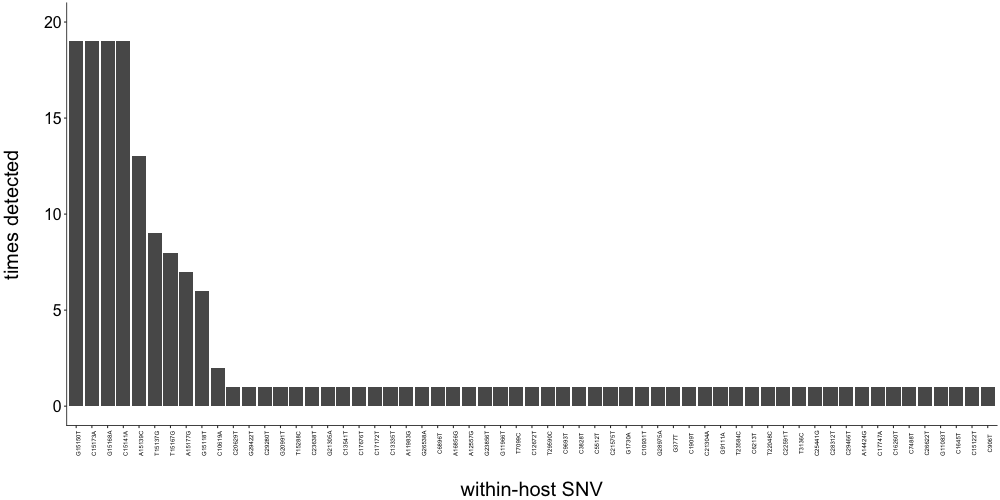

In [98]:
%%R -w 1000 -h 500 -u px -i s,s_color,ns_color,stop_color,fs_color,fs_stop_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

s$SNV_f = factor(s$SNV, levels=c('G15150T', 'C15173A', 'G15168A', 'C15141A', 'C14408T', 'C3037T', 'A23403G', 'A15139C', 'G25563T', 'T15137G', 'T15167G', 'A15177G', 'C1059T', 'G15118T', 'T14073C', 'A23947G', 'G11417T', 'C8782T', 'T28144C', 'T27348C', 'C17747T', 'G6884T', 'C18877T', 'A27338G', 'G15760A', 'A17858G', 'C10619A', 'C18060T', 'C20629T', 'G29422T', 'T15366C', 'C29280T', 'C29296T', 'G20991T', 'T15288C', 'C28677T', 'C7945T', 'C23638T', 'G16381A', 'C18481T', 'G21305A', 'C13541T', 'G20752T', 'C17676T', 'C17172T', 'G28878A', 'C13335T', 'A11983G', 'G26538A', 'C6896T', 'A16856G', 'A12557G', 'G23856T', 'G11966T', 'T7099C', 'C12672T', 'T29590C', 'C9693T', 'C3828T', 'C5512T', 'C21575T', 'G1730A', 'C10931T', 'G28975A', 'G377T', 'C1909T', 'C21304A', 'G9111A', 'T23584C', 'T28930C', 'C6213T', 'T22048C', 'C22591T', 'G25687A', 'C2416T', 'T3136C', 'C25441G', 'C28312T', 'C29466T', 'G9053C', 'G20326A', 'A14424G', 'C17747A', 'T17877C', 'C16260T', 'C7488T', 'C14407T', 'T29008C', 'C26622T', 'G25500T', 'G11083T', 'C1645T', 'C15122T', 'C20316T', 'G3871T', 'C906T'))

p2 <- ggplot(s, aes(x=SNV_f, y=counts))+
    geom_col()+
    scale_color_manual(values=c(stop=stop_color, missense=ns_color, synonymous=s_color,frameshift=fs_color,frameshift_stop=fs_stop_color))+
    scale_fill_manual(values=c(stop=stop_color, missense=ns_color, synonymous=s_color,frameshift=fs_color,frameshift_stop=fs_stop_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,20))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, size=6, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave("counts-low-freq-variants-2020-06-30.pdf", p2, width = 8, height = 4, path="/Users/lmoncla/src/ncov-WI-within-host/figures/")
p2

In [99]:
sloth = snvs_only[snvs_only['nuc_muts'] == 'G11083T']
sloth

,Unnamed: 0,SNP,POS,REF,annotation,gene_x,nt_change,aa_chage,rep1_percent,rep2_percent,%,sampleid,strain_name,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts
8,9,ORF1ab_10818G>T_Leu3606Phe_missense,11083.0,G,missense,ORF1ab,10818G>T,Leu3606Phe,1.12,1.52,1.32,28,USA/WI-UW-48/2020,3606,Leu,Phe,G,T,G11083T


## Test to see whether any of the recurrent variants are in this dataset

Using the list of putative masked variants [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473), see if any of these sites are present in the within-host data. 

This paragraph of that blog is particularly useful. They split up all of the consensus sequences into those generated by nanopore, Illumina, or by KU Leuven. This is what they found: 

`We re-analysed these 3 datasets individually using TreeTime. The most predominant homoplasies were common across technology and country, including G11083T, C16887T, C21575T and C15324T. Others were exclusive to Illumina (most remarkably C11074T, C6990T, C29353T, and C29774T) while others were exclusive to nanopore. Surprisingly dataset C contained more homoplasies than B (Figure 8), of which many are mutations only found in C (e.g. T13402G, A4050C, T13408C, T8022G, C3130T, T28785G). Each of these homoplasies could in principle also be caused by issues with phylogenetic inference, which itself can be affected by homoplasic substitutions.`

They also note that some of these recurrent mutations, like at 11083 and 11074 extend long homopolymer T regions. 11074 is also Illumina specific in their analysis. They note that 11083 reverts multiple times on the tree as well.

In [16]:
masked_sites = [187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700, 4050, 13402, 11083, 15324, 21575]
all_unique_within_host_sites = all_intersection_variants['POS'].tolist()
in_dataframe = []

for m in masked_sites: 
    if m in all_unique_within_host_sites:
        print(m)
        in_dataframe.append(m)

1059
3037
11074
25563
11083
21575


In [16]:
# output rows containing one of these masked sites 
all_intersection_variants[all_intersection_variants['POS'].isin(masked_sites)]

NameError: name 'masked_sites' is not defined

So...a lot of the shared variants do appear to be at these sites that they masked. There is a long thread in our slack about this, and Trevor does not seem to think that these are issues. I'm not really sure what to think to be honest. (link to slack: https://bedfordlab.slack.com/archives/CSKMU6YUC/p1589287709383400). 

After reading a bit more about this in detail, it seems like 11083 might just be a real, hypermutable spot. I think that given how well-characterized this within-host data is, that would be a nice addition to the literature (because they have duplicate sequencing and will have sequenced with 2 different methods). I find the Illumina specific mutations a little weird. I guess I do also wonder what is causing these specific mutations. Illumina sequencing has exceptionally low error rates and I would be shocked if these were induced by the sequencer itself. I would find it much more likely that this has to do with RT-PCR primers and cycling conditions. But not sure. 

## Plot a frequency distribution

I would really like to see a frequency distribution, because this would help me think about whether the patterns we see here are roughly neutral or not

In [20]:
def transform_percent(value: float):    
    if value <= 10:
        return('1-10%')
    elif value > 10 and value <=20: 
        return('10-20%')
    elif value > 20 and value <=30: 
        return('20-30%')
    elif value > 30 and value <=40: 
        return('30-40%')
    elif value > 40 and value <=50: 
        return('40-50%')
    elif value > 50 and value <=60: 
        return('50-60%')
    elif value > 60 and value <=70: 
        return('60-70%')
    elif value > 70 and value <=80: 
        return('70-80%')
    elif value > 80 and value <=90: 
        return('80-90%')
    elif value > 90 and value <=100: 
        return('90-100%')

In [21]:
def generate_frequency_bins(df):
    # assign bins to each SNP frequency value
    temp_df = pd.DataFrame(df)
    bin_series = df['%'].apply(transform_percent)
    temp_df["bin"] = bin_series
    return(df)

In [22]:
def generate_counts_df(df):
    
    df_to_return = pd.DataFrame()
    
    for strain in set(df['strain_name'].tolist()):
        for mut_type in set(df['annotation'].tolist()):
            d = df[(df['strain_name'] == strain) & (df['annotation'] == mut_type)]
            d = d[['bin']]
            d = pd.DataFrame(d.groupby(['bin']).size())
            d.reset_index(inplace=True)
            d.columns = ['bin','count']
            total_snvs = d['count'].sum()
            d['proportion'] = d['count']/total_snvs
            d['strain_name'] = strain
            d['type'] = mut_type

            df_to_return = df_to_return.append(d)
    

    return(df_to_return)

In [23]:
# add in frequency bins and generate a counts dataframe
snvs_freq1 = generate_frequency_bins(low_freq_snvs_only)
snvs_freq = generate_counts_df(snvs_freq1)
snvs_freq.head()

,bin,count,proportion,strain_name,type
0,1-10%,2,1.0,USA/WI-UW-41/2020,synonymous
0,1-10%,4,1.0,USA/WI-UW-41/2020,missense
0,1-10%,1,1.0,USA/WI-UW-41/2020,stop
0,1-10%,7,1.0,USA/WI-UW-87/2020,synonymous
0,1-10%,4,1.0,USA/WI-UW-87/2020,missense


In [24]:
# repeat for indels
indels_freq1 = generate_frequency_bins(low_freq_indels_only)
indels_freq = generate_counts_df(indels_freq1)
indels_freq.head()

,bin,count,proportion,strain_name,type
0,1-10%,2,1.000000,USA/WI-UW-41/2020,frameshift&stop
0,1-10%,12,0.923077,USA/WI-UW-41/2020,frameshift
1,10-20%,1,0.076923,USA/WI-UW-41/2020,frameshift
0,1-10%,1,1.000000,USA/WI-UW-87/2020,frameshift&stop
0,1-10%,4,1.000000,USA/WI-UW-87/2020,frameshift


### Bootstrap values and find mean across samples

We really should have error bars on these plots, and I think it'll be good to do this with bootstrapping

In [25]:
def fill_in_missing_values(values,sampling_value):
    missing_values = sampling_value - len(values)
    
    for i in range(missing_values):
        values.append(0.0)
    return(values)

In [26]:
def bootrap_values(values, iterations, sampling_value):
    bootstrapped_means = []
    
    for i in range(iterations):
        sample = np.random.choice(values, sampling_value, replace=True)
        mean = np.asarray(sample).mean()
        bootstrapped_means.append(mean)
    
    bootstrapped_means_array = np.array(bootstrapped_means)
    a = np.quantile(bootstrapped_means_array, 0.975)
    b = np.quantile(bootstrapped_means_array, 0.025)
    c = np.std(bootstrapped_means_array)
    
    return(a,b,c)

In [27]:
def run_bootstrap_iterations(df, iterations):
    
    freq_spec = pd.DataFrame()
    sampling_value = len(set(all_intersection_variants['strain_name'].tolist()))

    for freq_bin in set(df['bin'].tolist()):
        for p in set(df['type'].tolist()):

            d = df[(df['bin'] == freq_bin) & (df['type'] == p)]
            values = d['proportion'].tolist()

            values = fill_in_missing_values(values,sampling_value)
            mean = np.asarray(values).mean()
            a,b,c = bootrap_values(values, iterations, sampling_value)

            # generate dataframe 
            x = pd.DataFrame({"bin":[freq_bin],"type":[p],"mean":[mean],
                                "bootstrap_lower":[b],"bootstrap_upper":[a],"se_mean":[c]})
            freq_spec = freq_spec.append(x)
            
    return(freq_spec)

In [28]:
freq_spec_snvs = run_bootstrap_iterations(snvs_freq, 1000)
freq_spec_snvs.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean
0,10-20%,synonymous,0.030702,0.000000,0.074561,0.019852
0,10-20%,missense,0.034211,0.000000,0.071053,0.018378
0,10-20%,stop,0.000000,0.000000,0.000000,0.000000
0,1-10%,synonymous,0.969298,0.921053,1.000000,0.020658
0,1-10%,missense,0.965789,0.923684,1.000000,0.018524


In [29]:
freq_spec_indels = run_bootstrap_iterations(indels_freq, 1000)
freq_spec_indels.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean
0,10-20%,frameshift&stop,0.000000,0.000000,0.000000,0.000000
0,10-20%,frameshift,0.008833,0.000000,0.020979,0.005677
0,1-10%,frameshift&stop,0.947368,0.842105,1.000000,0.052576
0,1-10%,frameshift,0.991167,0.978285,1.000000,0.005726


In [30]:
freq_spec = freq_spec_snvs.append(freq_spec_indels)
freq_spec.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean
0,10-20%,synonymous,0.030702,0.000000,0.074561,0.019852
0,10-20%,missense,0.034211,0.000000,0.071053,0.018378
0,10-20%,stop,0.000000,0.000000,0.000000,0.000000
0,1-10%,synonymous,0.969298,0.921053,1.000000,0.020658
0,1-10%,missense,0.965789,0.923684,1.000000,0.018524


### Add in neutral expectation as a dashed line

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value. 

In [31]:
from scipy.integrate import quad

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

In [32]:
def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

In [33]:
def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [34]:
bins = [0.01,0.1,0.2,0.3,0.4,0.5]
#bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%"],"expected":proportions})
#neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"],"expected":proportions})

types = []
for i in range(len(neutral_df)):
    types.append("missense")
for i in range(len(neutral_df)):
    types.append("synonymous")
for i in range(len(neutral_df)):
    types.append("stop")
for i in range(len(neutral_df)):
    types.append("frameshift")
for i in range(len(neutral_df)):
    types.append("frameshift&stop")
    
neutral_df = neutral_df.append(neutral_df).append(neutral_df).append(neutral_df).append(neutral_df)
neutral_df['type'] = types
neutral_df.head()

,bin,expected,type
0,1-10%,0.588592,missense
1,10-20%,0.177184,missense
2,20-30%,0.103646,missense
3,30-40%,0.073538,missense
4,40-50%,0.057040,missense


In [35]:
freq_spec_neutral = freq_spec.merge(neutral_df, on=["bin","type"], how="outer")
freq_spec_neutral = freq_spec_neutral.fillna(0)
freq_spec_neutral.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean,expected
0,10-20%,synonymous,0.030702,0.000000,0.074561,0.019852,0.177184
1,10-20%,missense,0.034211,0.000000,0.071053,0.018378,0.177184
2,10-20%,stop,0.000000,0.000000,0.000000,0.000000,0.177184
3,1-10%,synonymous,0.969298,0.921053,1.000000,0.020658,0.588592
4,1-10%,missense,0.965789,0.923684,1.000000,0.018524,0.588592


In [36]:
s_color = "#A5CDA2"
ns_color = "#0E7908"
stop_color = "#073C04"
fs_color = "#00357D"
fs_stop_color = "#00142F"

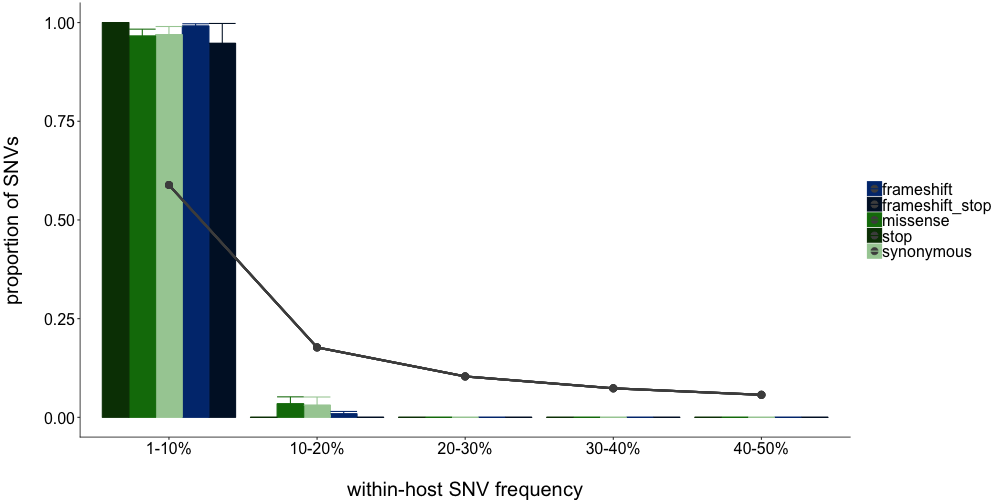

In [64]:
%%R -w 1000 -h 500 -u px -i freq_spec_neutral,s_color,ns_color,stop_color,fs_color,fs_stop_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

freq_spec_neutral$type <- gsub('&', '_', freq_spec_neutral$type)
freq_spec_neutral$typef = factor(freq_spec_neutral$type, levels=c("stop","missense","synonymous","frameshift","frameshift_stop"))

p3 <- ggplot(freq_spec_neutral, aes(x=bin, y=mean,color=type, fill=type, group=typef))+
    geom_col(position="dodge")+
    geom_point(data=freq_spec_neutral, aes(x=bin,y=expected), size=3, color="grey30")+
    geom_line(data=freq_spec_neutral, aes(x=bin,y=expected), linetype=1, size=1, color="grey30")+
    scale_color_manual(values=c(stop=stop_color, missense=ns_color, synonymous=s_color,frameshift=fs_color,frameshift_stop=fs_stop_color))+
    scale_fill_manual(values=c(stop=stop_color, missense=ns_color, synonymous=s_color,frameshift=fs_color,frameshift_stop=fs_stop_color))+
    geom_errorbar(data=freq_spec_neutral, aes(x=bin, ymin = mean, ymax = mean + se_mean),position="dodge")+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, size=16, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV frequency",y="proportion of SNVs\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave("frequency-spectrum-2020-06-18.pdf", p3, width = 8, height = 4, path="/Users/lmoncla/src/ncov-WI-within-host/figures/")
p3

This looks to me very expected, where we have a large excess of low frequency variation, consistent with population expansion. It's actually pretty remarkable how similar the distributions are for synonymous and nonsynonymous variation. 

## Functions for parsing tree from nextstrain

The idea here will be to answer the following questions: 
1. What proportion of within-host variants are present on the tree? 
2. Do within-host variants have a skew towards being on internal vs. terminal branches, relative to the rest of the tree? If within-host variants are mostly deleterious, we would hypothesize that they should occur on the tree rarely and should be localized primarily to internal nodes. 
3. Are variants that are detected within-host in a given sample ever detected at consensus downstream of that sample? If the bottleneck is small and random, then I would not really expect to see this. If however, the bottleneck is really wide, then we might expect to observe this more often. The results here will need to be intergrated with Kat's actual estimates. 

In [37]:
def generate_snvs_dict_for_tree(query_list):
    snvs_on_tree = {}
    for q in query_list: 
        snvs_on_tree[q] = {"branches_with_snv":[], "arose_on_tip":0, "arose_on_internal_node":0}
    
    return(snvs_on_tree)

In [38]:
def enumerate_mutations_on_branches(tree, snvs_on_tree):    
    for k in tree.Objects:
        if 'branch_attrs' in k.traits:
            if 'mutations' in k.traits['branch_attrs']:
                if 'nuc' in k.traits['branch_attrs']['mutations']:
                    nt_muts = k.traits['branch_attrs']['mutations']['nuc']
                    for n in nt_muts: 
                        if n in snvs_on_tree:
                            snvs_on_tree[n]["branches_with_snv"].append(k.name)
                            
                            if k.branchType == "node":
                                leaves = 0 #len(k.leaves)
                                nodes = 1
                            elif k.branchType == "leaf":
                                leaves = 1
                                nodes = 0
                            
                            snvs_on_tree[n]["arose_on_tip"] += leaves
                            snvs_on_tree[n]["arose_on_internal_node"] += nodes
                            
    return(snvs_on_tree)

In [39]:
def enumerate_all_tree_muts(tree):
    
    all_snps_on_tree = {}
    total_snps = {"internal_nodes": 0, "tips":0}
    
    for k in tree.Objects:
        if 'branch_attrs' in k.traits:
            if 'mutations' in k.traits['branch_attrs']:
                if 'nuc' in k.traits['branch_attrs']['mutations']:
                    nt_muts = k.traits['branch_attrs']['mutations']['nuc']
                    for n in nt_muts:
                        if n not in all_snps_on_tree: 
                            all_snps_on_tree[n] = {"branches_with_snv":[], "arose_on_tip":0, "arose_on_internal_node":0}
                        
                        all_snps_on_tree[n]["branches_with_snv"].append(k.name)

                        if k.branchType == "node":
                            leaves = 0 #len(k.leaves)
                            nodes = 1
                        elif k.branchType == "leaf":
                            leaves = 1
                            nodes = 0

                        all_snps_on_tree[n]["arose_on_tip"] += leaves
                        all_snps_on_tree[n]["arose_on_internal_node"] += nodes
                            
                    
                    if k.branchType == "node":
                        total_snps["internal_nodes"] += len(nt_muts)
                    elif k.branchType == "leaf":
                        total_snps['tips'] += len(nt_muts)
                        
    return(all_snps_on_tree, total_snps)

## Grab the most recent json file from nextstrain, and read it in as a baltic tree object 

The current `json_translation` defined here will translate auspice v2 jsons attributes into the proper tree attributes. This will not work for auspice v1 jsons. All ncov jsons are in v2. 

In [40]:
json_url='http://data.nextstrain.org/ncov_global.json'
tree_json=json.load(csio(requests.get(json_url).content))
analysis_level = "division"

tree_object=tree_json['tree']
meta=tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
json_meta={'file':meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

tree=bt.loadJSON(tree_object,json_translation,json_meta)


Tree height: 0.495140
Tree length: 203.711053
multitype tree
annotations present

Numbers of objects in tree: 5653 (2560 nodes and 3093 leaves)



In [41]:
snvs_on_tree_dict = generate_snvs_dict_for_tree(all_variants_to_query)
snvs_on_tree_dict = enumerate_mutations_on_branches(tree, snvs_on_tree_dict)
full_tree_muts,tree_mut_counts = enumerate_all_tree_muts(tree)

In [42]:
snvs_on_tree_dict

{'G15150T': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 'C23638T': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 '507GTCATGTTATGGTTG-': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 'A14424G': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 '-11812A': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 'A11983G': {'branches_with_snv': ['Ecuador/USFQ-097/2020'],
  'arose_on_tip': 1,
  'arose_on_internal_node': 0},
 '-6696T': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 'G9111A': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 'A16856G': {'branches_with_snv': [],
  'arose_on_tip': 0,
  'arose_on_internal_node': 0},
 'C12672T': {'branches_with_snv': ['France/OCC-17/2020'],
  'arose_on_tip': 1,
  'arose_on_internal_node': 0},
 'G26538A': {'branches_with_snv': [],

In [43]:
full_tree_df = pd.DataFrame.from_dict(full_tree_muts, orient="index")
full_tree_df.reset_index(inplace=True)
full_tree_df.columns = ['snv','branches_with_snv','arose_on_tip','arose_on_internal_node']
full_tree_df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,-1605A,"[Ecuador/HEE-01/2020, Israel/CVL-n-6100/2020]",2,0
1,-1606C,[Israel/CVL-n-6100/2020],1,0
2,-1606T,"[Ecuador/HEE-01/2020, NewZealand/20VR2941/2020]",2,0
3,-1607A,[Switzerland/140032/2020],1,0
4,-1607G,"[Ecuador/HEE-01/2020, Israel/CVL-n-6100/2020, ...",3,0


In [44]:
snps_on_tips = full_tree_df['arose_on_tip'].sum()
snps_on_nodes = full_tree_df['arose_on_internal_node'].sum()
print(tree_mut_counts)

{'internal_nodes': 2102, 'tips': 6440}


In [45]:
df = pd.DataFrame.from_dict(snvs_on_tree_dict, orient="index")
df.reset_index(inplace=True)
df.columns = ['snv','branches_with_snv','arose_on_tip','arose_on_internal_node']
df1 = df[['snv','arose_on_tip','arose_on_internal_node']]
df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,-10619A,[],0,0
1,-11074T,[],0,0
2,-11095T,[],0,0
3,-1135A,[],0,0
4,-11812A,[],0,0


In [46]:
# print number/fraction of SNVs that are never on the tree 
not_on_tree = len(df[(df['arose_on_tip'] == 0) & (df['arose_on_internal_node'] == 0)])
print(not_on_tree)
print(len(df))
print("the total fraction of within-host SNVs that are found on the tree is ", (len(df)-not_on_tree)/len(df))
print("the total fraction of within-host SNVs that are NOT found on the tree is ", not_on_tree/len(df))

69
90
the total fraction of within-host SNVs that are found on the tree is  0.23333333333333334
the total fraction of within-host SNVs that are NOT found on the tree is  0.7666666666666667


### Question 1: What fraction of variants are on the tree? 

~70% of variants detected within-host are never detected on the tree at all. 

In [47]:
# for all within-host variants added together, print the number of times they appear on tips and on internal nodes
within_host_on_tips = df['arose_on_tip'].sum()
within_host_on_nodes = df['arose_on_internal_node'].sum()
print(within_host_on_tips, within_host_on_nodes)

46 17


In [48]:
# do a Fisher's exact test, testing whether within-host variants have a different ratio of internal node to terminal
# node appearance than other mutations on the tree
import scipy
from scipy import stats
table = [[snps_on_nodes,snps_on_tips],[within_host_on_nodes,within_host_on_tips]]
stats.fisher_exact(table)

(0.8831932773109243, 0.6605534692433432)

This suggests that they do. Overall, this suggests that while on the tree, the ratio of internal node mutations to tip mutations is 1:4, for within-host variants, that ratio is more like 1:2. Which is really weird. I'm not sure how to explain that. 

In [49]:
# compare with Fishers exact test 
# now run on actual data
import scipy 
from scipy import stats

p_values = {}

for index, row in df.iterrows():
    mutation = row['snv']
    on_tips = row['arose_on_tip']
    on_internal_nodes = row['arose_on_internal_node']
    
    table = [[snps_on_nodes,snps_on_tips],[on_internal_nodes,on_tips]]
    p_value = (stats.fisher_exact(table))[1]
        
    if p_value < 0.05:
        print(mutation, p_value)
        
    # assign stars
    if p_value > 0.01 and p_value < 0.05:
        significance = "*"

    elif p_value > 0.001 and p_value < 0.01:
        significance = "**"
        
    elif p_value > 0.0001 and p_value < 0.001:
        significance = "***"
    
    elif p_value < 0.0001:
        significance = "****"
        
    else: 
        significance = ""
            
    p_values[mutation] = {"p_value":p_value, "significance":significance}

In [50]:
p_values

{'-10619A': {'p_value': 1.0, 'significance': ''},
 '-11074T': {'p_value': 1.0, 'significance': ''},
 '-11095T': {'p_value': 1.0, 'significance': ''},
 '-1135A': {'p_value': 1.0, 'significance': ''},
 '-11812A': {'p_value': 1.0, 'significance': ''},
 '-13459T': {'p_value': 1.0, 'significance': ''},
 '-15965T': {'p_value': 1.0, 'significance': ''},
 '-16501T': {'p_value': 1.0, 'significance': ''},
 '-18058T': {'p_value': 1.0, 'significance': ''},
 '-1813A': {'p_value': 1.0, 'significance': ''},
 '-18368T': {'p_value': 1.0, 'significance': ''},
 '-19231T': {'p_value': 1.0, 'significance': ''},
 '-19983T': {'p_value': 1.0, 'significance': ''},
 '-20091A': {'p_value': 1.0, 'significance': ''},
 '-20908T': {'p_value': 1.0, 'significance': ''},
 '-23903T': {'p_value': 1.0, 'significance': ''},
 '-24223T': {'p_value': 1.0, 'significance': ''},
 '-25797A': {'p_value': 1.0, 'significance': ''},
 '-27175T': {'p_value': 1.0, 'significance': ''},
 '-27691T': {'p_value': 1.0, 'significance': ''},
 '

In [106]:
print(len(df[df['arose_on_tip'] == 0]))
print(len(df[df['arose_on_tip'] > 0]))
print(len(df))

72
18
90


In [51]:
print(len(df[df['arose_on_internal_node'] == 0]))
print(len(df[df['arose_on_internal_node'] > 0]))
print(len(df))

82
8
90


In [52]:
df2 = df[df['arose_on_internal_node'] > 0]
df2

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
45,C16260T,"[Singapore/398/2020, NODE_0001340, Sweden/20-5...",2,1
53,C21575T,"[Singapore/17/2020, Belgium/ULG-10009/2020, US...",7,1
62,C5512T,"[NODE_0000960, DRC/2819/2020]",1,1
67,C9693T,[NODE_0002363],0,1
68,G11083T,"[NODE_0000309, India/ILSCV14289/2020, USA/AZ1/...",16,10
76,G23856T,[NODE_0002825],0,1
79,G29422T,"[Hungary/SRC-00792/2020, Germany/NRW-32/2020, ...",5,1
88,T3136C,[NODE_0003056],0,1


In [53]:
df3 = df[df['arose_on_tip'] > 0]
df3

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
31,A11983G,[Ecuador/USFQ-097/2020],1,0
32,A12557G,[USA/CA-CZB-1267/2020],1,0
39,C12672T,[France/OCC-17/2020],1,0
40,C13335T,[Japan/Donner30/2020],1,0
45,C16260T,"[Singapore/398/2020, NODE_0001340, Sweden/20-5...",2,1
48,C17676T,"[Israel/51140836/2020, Sichuan/SC-WCH4-301/2020]",2,0
50,C1909T,[England/BIRM-5E2C1/2020],1,0
52,C21304A,"[Austria/CeMM0344/2020, Turkey/HSGM-5769/2020]",2,0
53,C21575T,"[Singapore/17/2020, Belgium/ULG-10009/2020, US...",7,1
59,C29280T,[Spain/Albacete-COV003838/2020],1,0


In [46]:
low_freq_only[low_freq_only['nuc_muts'] == 'G11083T']

,Unnamed: 0,SNP,POS,REF,annotation,gene_x,nt_change,aa_chage,rep1_percent,rep2_percent,%,sampleid,strain_name,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts
8,9,ORF1ab_10818G>T_Leu3606Phe_missense,11083.0,G,missense,ORF1ab,10818G>T,Leu3606Phe,1.12,1.52,1.32,28,USA/WI-UW-48/2020,3606,Leu,Phe,G,T,G11083T


In [47]:
low_freq_only[low_freq_only['nuc_muts'] == 'C21575T']

,Unnamed: 0,SNP,POS,REF,annotation,gene_x,nt_change,aa_chage,rep1_percent,rep2_percent,%,sampleid,strain_name,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts
18,24,S_13C>T_Leu5Phe_missense,21575.0,C,missense,S,13C>T,Leu5Phe,1.71,1.25,1.48,74,USA/WI-UW-84/2020,5,Leu,Phe,C,T,C21575T


In [110]:
df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,-10619A,[],0,0
1,-11074T,[],0,0
2,-11095T,[],0,0
3,-1135A,[],0,0
4,-11812A,[],0,0


In [111]:
df_to_plot = df.copy()
df_to_plot = df_to_plot.melt(value_vars=['arose_on_tip','arose_on_internal_node'], id_vars=['snv'])
df_to_plot.head()

,snv,variable,value
0,-10619A,arose_on_tip,0
1,-11074T,arose_on_tip,0
2,-11095T,arose_on_tip,0
3,-1135A,arose_on_tip,0
4,-11812A,arose_on_tip,0


In [112]:
tip_color = "#C75643"
node_color = "#545AB7"

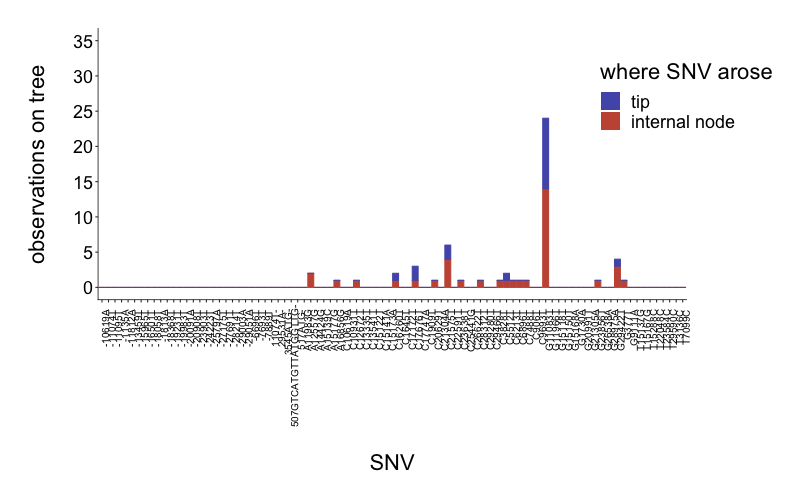

In [115]:
%%R -w 800 -h 500 -u px -i df_to_plot,tip_color,node_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


p <- ggplot(data=df_to_plot, aes(x=snv, y=value, color=variable, fill=variable)) + 
    geom_col()+
    labs(x="\nSNV",y="observations on tree\n")+
    scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
    scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=10, colour="black", angle=90, hjust=0.95))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave("SNVS-on-tree-2020-06-18.pdf", width = 16, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p

## Do within-host variants appear downstream of the sample they were taken from?



In [70]:
# test this out first on the Wisconsin-only build json
#WI_tree_path = "/Users/lmoncla/src/ncov-WI-within-host/data/Wisconsin.json"
WI_tree_path = "/Volumes/gradschool-and-postdoc-backups/post-doc/stored_files_too_big_for_laptop/ncov-build-forced-WI/ncov/auspice/ncov_global.json"

with open(WI_tree_path) as json_file:
    WI_tree_json = json.load(json_file)
WI_tree_object=WI_tree_json['tree']
WI_meta=tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
json_meta={'file':meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

WI_tree=bt.loadJSON(WI_tree_object,json_translation,json_meta)


Tree height: 0.431415
Tree length: 207.719461
multitype tree
annotations present

Numbers of objects in tree: 8015 (3630 nodes and 4385 leaves)



In [71]:
strain_names_to_query = list(set(all_intersection_variants['strain_name']))
print(strain_names_to_query)
print(len(strain_names_to_query))

['USA/WI-UW-87/2020', 'USA/WI-UW-74/2020', 'USA/WI-UW-76/2020', 'USA/WI-UW-68/2020', 'USA/WI-UW-120/2020', 'USA/WI-UW-70/2020', 'USA/WI-UW-45/2020', 'USA/WI-UW-52/2020', 'USA/WI-UW-111/2020', 'USA/WI-UW-84/2020', 'USA/WI-UW-48/2020', 'USA/WI-UW-32/2020', 'USA/WI-UW-29/2020', 'USA/WI-UW-39/2020', 'USA/WI-UW-30/2020', 'USA/WI-UW-119/2020', 'USA/WI-UW-41/2020', 'USA/WI-UW-65/2020', 'USA/WI-UW-110/2020']
19


In [72]:
def return_within_host_muts_for_branch(branch, df):
    d = df[df['strain_name'] == branch.name]
    within_host_muts = d['nuc_muts'].to_list()
    return(within_host_muts)

In [73]:
def return_proper_parent_node(node):
    """given an internal node, traverse back up the tree to find a parental node with a 
    real branch length (basically, collapse the polytomy). This is necessary for most 
    tree software, including iqtree and treetime, which both normally atempt to resolve
    polytomies, resulting in a fully bifurcating tree with lots of very tiny branches"""
    
    #print(node, node.length)
    if abs(node.traits['node_attrs']['div'] - node.parent.traits['node_attrs']['div']) < 0.0000000001: 
        
        #print("going up 1 node")
        if node.parent !=None:
            parent_node = return_proper_parent_node(node.parent)
        
        else:
            #print("root is proper parent")
            parent_node = node
    
    else: 
        #print("current node has proper length")
        parent_node = node
    
    return(parent_node)

In [74]:
def return_nt_muts_on_branch(branch):
    nt_muts = []
    if 'branch_attrs' in branch.traits:
        if 'mutations' in branch.traits['branch_attrs']:
            if 'nuc' in branch.traits['branch_attrs']['mutations']:
                nt_muts = branch.traits['branch_attrs']['mutations']['nuc']
                            
    return(nt_muts)

In [75]:
"""Given a starting internal node, and a tip you would like to end at, traverse the full path from that node to
tip. Along the way, gather nucleotide mutations that occur along that path. Once you have reached the ending 
tip, return the list of mutations that fell along that path"""

def return_all_muts_on_path_to_tip(starting_node, ending_tip):
    
    # set an empty list of mutations and enumerate the children of the starting node; children can be tips or nodes
    muts = []
    children = starting_node.children
    
    for child in children:
        nt_muts = []
        
        """if the child is a leaf: if leaf is the target end tip, add the mutations that occur on that branch to the list
        and return the list; if leaf is not the target end tip, move on"""
        """if the child is an internal node: first, test whether that child node contains the target tips in its 
        children. child.leaves will output a list of the names of all tips descending from that node. If not, pass. 
        if the node does contain the target end tip in its leaves, keep traversing down that node recursively, 
        collecting mutations as you go"""

        if child.branchType == "leaf":
            if child.name != ending_tip:
                pass
            elif child.name == ending_tip:
                nt_muts = return_nt_muts_on_branch(child)
                for n in nt_muts:
                    muts.append(n)
                return(muts)
        
        
        elif child.branchType == "node":
            if ending_tip not in child.leaves:
                pass
            else:
                nt_muts = return_nt_muts_on_branch(child)
                for n in nt_muts:
                    muts.append(nt_muts)
                return_all_muts_on_path_to_tip(child, ending_tip)
    
    
    # flatten the list so that you don't have nested lists
    flat_list = [item for sublist in muts for item in sublist]
    return(flat_list)

In [76]:
for k in WI_tree.Objects: 
    
    """if the tip is one of the Wisconson sequences for which we have within-host data, pull out its division, 
    divergence value, and the divergence of its parent node"""
    if k.name in strain_names_to_query:
        
        k_within_host_muts = return_within_host_muts_for_branch(k, low_freq_only)
        
        if 'division' in k.traits['node_attrs']:
            division = k.traits['node_attrs']['division']['value']
            branch_length = k.traits['node_attrs']['div']
            parent_branch_length = k.parent.traits['node_attrs']['div']

            
            """if you lie on an internal node and are from Wisconsin, find the proper parent (collapsing very small
            branches induced by polytomy resolution) and return all children descending from that parent node"""
            if branch_length - parent_branch_length < 0.000000001:
                print(k.name, "lies on internal node")
                #if division == "Wisconsin":
                proper_parent = return_proper_parent_node(k.parent)
                child_tips = proper_parent.leaves
                #print(child_tips)
                
                """next, for child, traverse the path from parent to child, enumerating mutations that fall 
                along that path"""
                for c in child_tips:
                    mutations = return_all_muts_on_path_to_tip(proper_parent, c)
                    for m in mutations: 
                        if m in k_within_host_muts:
                            print(c, m)

USA/WI-UW-70/2020 lies on internal node
USA/WI-UW-76/2020 lies on internal node
USA/WI-UW-32/2020 lies on internal node
USA/WI-UW-65/2020 lies on internal node
USA/WI-UW-45/2020 lies on internal node
USA/WI-UW-68/2020 lies on internal node
USA/WI-UW-52/2020 lies on internal node
USA/WI-UW-74/2020 lies on internal node
USA/WI-UW-29/2020 lies on internal node
USA/WI-UW-41/2020 lies on internal node
USA/WI-UW-48/2020 lies on internal node


The putative transmission pairs in this analysis are: 

1. WI-65 and WI-32
2. WI-41 and WI-48
3. WI-74 and WI-29
4. WI-120 and WI-119

In [37]:
low_freq_only[low_freq_only['strain_name'] == 'USA/WI-UW-68/2020']

,Unnamed: 0,SNP,POS,REF,annotation,gene_x,nt_change,aa_chage,rep1_percent,rep2_percent,%,sampleid,strain_name,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts
2,4,ORF1ab_1644C>T_Phe548Phe_synonymous,1909.0,C,synonymous,ORF1ab,1644C>T,Phe548Phe,5.03,5.25,5.140,54,USA/WI-UW-68/2020,548,Phe,Phe,C,T,C1909T
4,7,ORF1ab_5948C>T_Ala1983Val_missense,6213.0,C,missense,ORF1ab,5948C>T,Ala1983Val,1.33,1.10,1.215,54,USA/WI-UW-68/2020,1983,Ala,Val,C,T,C6213T
10,14,ORF1ab_14854G>T_Val4952Phe_missense,15118.0,G,missense,ORF1ab,14854G>T,Val4952Phe,1.30,1.30,1.300,54,USA/WI-UW-68/2020,4952,Val,Phe,G,T,G15118T
11,16,ORF1ab_14875A>C_Thr4959Pro_missense,15139.0,A,missense,ORF1ab,14875A>C,Thr4959Pro,1.10,2.10,1.600,54,USA/WI-UW-68/2020,4959,Thr,Pro,A,C,A15139C
12,17,ORF1ab_14877C>A_Thr4959Thr_synonymous,15141.0,C,synonymous,ORF1ab,14877C>A,Thr4959Thr,2.30,1.70,2.000,54,USA/WI-UW-68/2020,4959,Thr,Thr,C,A,C15141A
13,18,ORF1ab_14886G>T_Gln4962His_missense,15150.0,G,missense,ORF1ab,14886G>T,Gln4962His,2.45,2.95,2.700,54,USA/WI-UW-68/2020,4962,Gln,His,G,T,G15150T
14,19,ORF1ab_14903T>G_Leu4968Trp_missense,15167.0,T,missense,ORF1ab,14903T>G,Leu4968Trp,1.20,1.20,1.200,54,USA/WI-UW-68/2020,4968,Leu,Trp,T,G,T15167G
15,20,ORF1ab_14904G>A_Leu4968Leu_synonymous,15168.0,G,synonymous,ORF1ab,14904G>A,Leu4968Leu,4.50,4.70,4.600,54,USA/WI-UW-68/2020,4968,Leu,Leu,G,A,G15168A
16,21,ORF1ab_14909C>A_Ser4970*_stop,15173.0,C,stop,ORF1ab,14909C>A,Ser4970*,3.10,2.15,2.625,54,USA/WI-UW-68/2020,49,Ser,70*,C,A,C15173A
22,27,ORF1ab_21040C>A_Arg7014Ser_missense,21304.0,C,missense,ORF1ab,21040C>A,Arg7014Ser,5.79,5.34,5.565,54,USA/WI-UW-68/2020,7014,Arg,Ser,C,A,C21304A


In [ ]:
import Bio
from Bio import SeqIO

count = 0
for seq in SeqIO.parse("/Volumes/gradschool-and-postdoc-backups/post-doc/stored_files_too_big_for_laptop/ncov-build-forced-WI/ncov/results/filtered.fasta", "fasta"):
    if "WI-UW" in seq.id:
        count += 1
    if seq.id == "USA/WI-UW-139/2020":
        print("sloth")
        
print(count)

353